In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency
from scipy.stats import zscore
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

# MODELAGEM COM KMeans

In [14]:
dados_clientes = pd.read_csv("C:/Projetos Pessoais/DataScience/segmentacao_Clientes_Ecomerce/data/dados_processados.csv")

In [15]:
dados_clientes.set_index('Cod_cliente', inplace = True)
dados_clientes

,Ultima_Compra,Total_transacoes,Valor_total_gasto,Avg_transacao,diversidade_produtos,Dia_fav_compra,UK,Gastos_medios_mensais,Desvio_padrao_gastos_mensais,Tendencia_gastos
Cod_cliente,,,,,,,,,,
12347,-1.020309,0.729262,1.440195,-0.032710,0.377870,1,0,0.036451,1.271037,0.063393
12348,-0.362931,-0.463437,0.051211,0.272704,-0.523048,3,0,-0.233072,0.554344,-0.587805
12349,-0.876226,-0.117169,0.061030,-0.068264,0.037279,0,0,0.921358,-0.510682,0.035669
12350,1.753284,-0.548080,-0.501355,-0.087281,-0.577982,2,0,-0.301303,-0.510682,0.035669
12352,-0.714133,-0.078695,0.026310,-0.091416,-0.127523,1,0,-0.246606,0.116406,0.019094
...,...,...,...,...,...,...,...,...,...,...
21821,-1.029314,-0.655807,-0.642078,-0.260091,-0.731797,3,1,-0.607244,-0.510682,0.035669
21822,-1.029314,4.207324,2.111779,-0.184538,6.211865,3,1,5.379817,-0.510682,0.035669
21823,-1.038319,4.946027,2.622869,-0.181851,7.266599,4,1,6.490961,-0.510682,0.035669


# Verificando o número ideal de clusters (K)

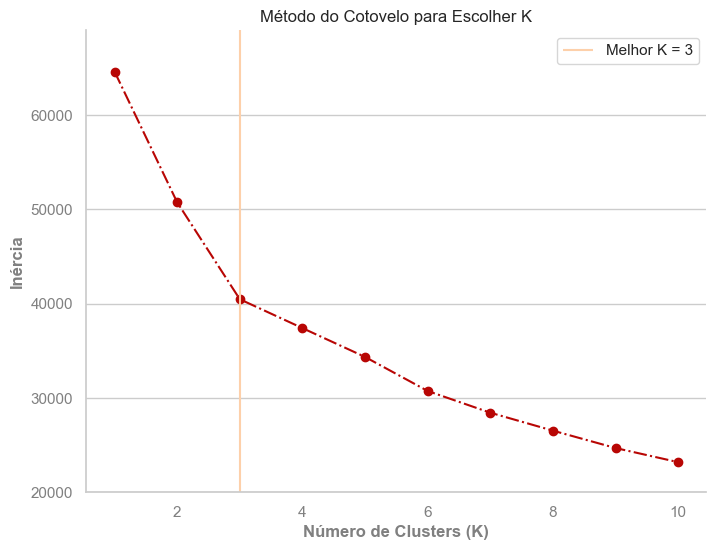

In [56]:
inercia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(dados_clientes)
    inercia.append(kmeans.inertia_)

sns.set(style="whitegrid")
sns.set_palette("OrRd_r")

# Plotar o método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inercia, marker='o', linestyle='dashdot')
plt.xlabel('Número de Clusters (K)', color = 'grey',fontweight='bold')
plt.ylabel('Inércia', color = 'grey',fontweight='bold')
plt.title('Método do Cotovelo para Escolher K')

# Melhor K
best_k = 3  # Suponha que o melhor K seja 3
plt.vlines(x=best_k, ymin=10000, ymax=700000, colors='#fdd0aa', linestyles='solid', label=f'Melhor K = {best_k}')

# Remover bordas direita e superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(color = 'grey')
plt.yticks(color = 'grey')

# Definir limite inferior e superior para eixo Y
plt.ylim(20000, 69000)

# Remover grid do eixo X
plt.gca().xaxis.grid(False)

plt.legend()
plt.show()

- Escolhi K = 3 pois é onde a curva de inercia começa a estabilizar

## Aplicando o algorítmo com K = 3

In [18]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
clusters = kmeans.fit_predict(dados_clientes)

In [19]:
# Criando a variável 'Cluster', para identificação de cada cluster
dados_clientes['Cluster'] = clusters

In [20]:
dados_clientes

,Ultima_Compra,Total_transacoes,Valor_total_gasto,Avg_transacao,diversidade_produtos,Dia_fav_compra,UK,Gastos_medios_mensais,Desvio_padrao_gastos_mensais,Tendencia_gastos,Cluster
Cod_cliente,,,,,,,,,,,
12347,-1.020309,0.729262,1.440195,-0.032710,0.377870,1,0,0.036451,1.271037,0.063393,1
12348,-0.362931,-0.463437,0.051211,0.272704,-0.523048,3,0,-0.233072,0.554344,-0.587805,0
12349,-0.876226,-0.117169,0.061030,-0.068264,0.037279,0,0,0.921358,-0.510682,0.035669,1
12350,1.753284,-0.548080,-0.501355,-0.087281,-0.577982,2,0,-0.301303,-0.510682,0.035669,1
12352,-0.714133,-0.078695,0.026310,-0.091416,-0.127523,1,0,-0.246606,0.116406,0.019094,1
...,...,...,...,...,...,...,...,...,...,...,...
21821,-1.029314,-0.655807,-0.642078,-0.260091,-0.731797,3,1,-0.607244,-0.510682,0.035669,0
21822,-1.029314,4.207324,2.111779,-0.184538,6.211865,3,1,5.379817,-0.510682,0.035669,2
21823,-1.038319,4.946027,2.622869,-0.181851,7.266599,4,1,6.490961,-0.510682,0.035669,2


In [30]:
dados_clientes.shape

(5510, 11)

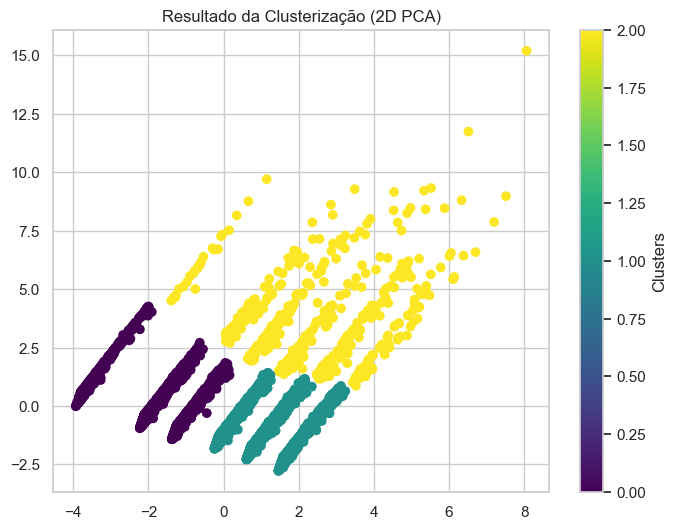

In [83]:
# Visualização da distribuição dos clusters

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(dados_clientes)

# Defina a paleta de cores
custom_cmap = plt.get_cmap('viridis')  # Você pode substituir 'viridis' pela paleta desejada

plt.figure(figsize=(8, 6))

# Use a paleta de cores para os pontos do gráfico de dispersão
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, pallete=custom_cmap)

# Adicione uma barra de cores para representar os valores das clusters
cbar = plt.colorbar(scatter)
cbar.set_label('Clusters')

plt.title('Resultado da Clusterização (2D PCA)')
plt.show()

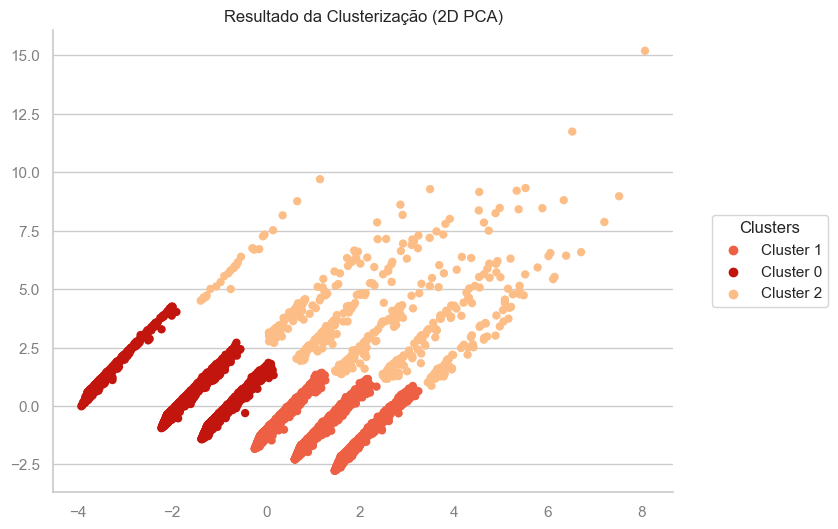

In [108]:
# Redimensionando os dados para plotar gráfico 2d
pca = PCA(n_components=2)
data_pca = pca.fit_transform(dados_clientes)

# Defina a paleta de cores personalizada
custom_palette = ['#ed6044', '#c2150d', '#fdbd86']  # Substitua as cores conforme sua preferência

# Mapear os rótulos originais para os rótulos personalizados
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'}
custom_labels = [cluster_labels[label] for label in clusters]

plt.figure(figsize=(8, 6))

# Use o Seaborn para criar o gráfico de dispersão com os rótulos personalizados
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=custom_labels, palette=custom_palette, edgecolor="None")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(color = 'grey')
plt.yticks(color = 'grey')
# Remover grid do eixo X
plt.gca().xaxis.grid(False)

# Centraliza o box da legenda
plt.legend(title='Clusters', loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.title('Resultado da Clusterização (2D PCA)')
plt.show()

In [23]:
# Quantidade de clientes por cluster
df_cluster = dados_clientes['Cluster'].value_counts().reset_index()

# Criação da variável Porcentagem
df_cluster['Porcentagem (%)'] = round((df_cluster['count'] / df_cluster['count'].sum()) * 100, 2)
df_cluster = df_cluster.drop(columns = ['count'])
df_cluster

,Cluster,Porcentagem (%)
0,1,47.19
1,0,42.92
2,2,9.89


In [24]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cluster          3 non-null      int32  
 1   Porcentagem (%)  3 non-null      float64
dtypes: float64(1), int32(1)
memory usage: 164.0 bytes


In [25]:
# Renomeando Cluster
def renomeia_cluster(x):
    if x == 0:
        return 'Cluster 0'
    elif x == 1:
        return 'Cluster 1'
    elif x == 2:
        return 'Cluster 2'
    
df_cluster['Cluster'] = df_cluster['Cluster'].map(renomeia_cluster)
df_cluster

,Cluster,Porcentagem (%)
0,Cluster 1,47.19
1,Cluster 0,42.92
2,Cluster 2,9.89


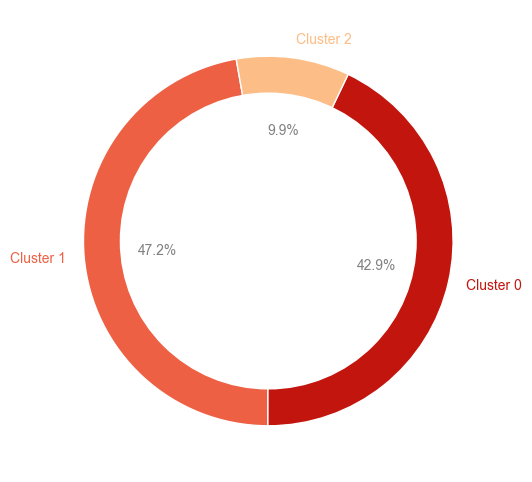

In [109]:
custom_colors = ['#ed6044', '#c2150d', '#fdbd86']
plt.figure(figsize=(10, 6))

# Desenhar o gráfico de pizza com as quantidades e as cores personalizadas
wedges, texts, autotexts = plt.pie(df_cluster['Porcentagem (%)'], labels=df_cluster['Cluster'],
                                   autopct='%1.1f%%', startangle=100, colors=custom_colors)  # Adicione a lista de cores personalizadas

# Configurar as propriedades dos textos
for text, color in zip(texts, custom_colors):
    text.set(color=color, size=10)  # Define a cor e o tamanho do texto de acordo com a lista de cores personalizadas

plt.setp(autotexts, size=10, color='grey')
    
centre_circle = plt.Circle((0, 0), 0.8, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

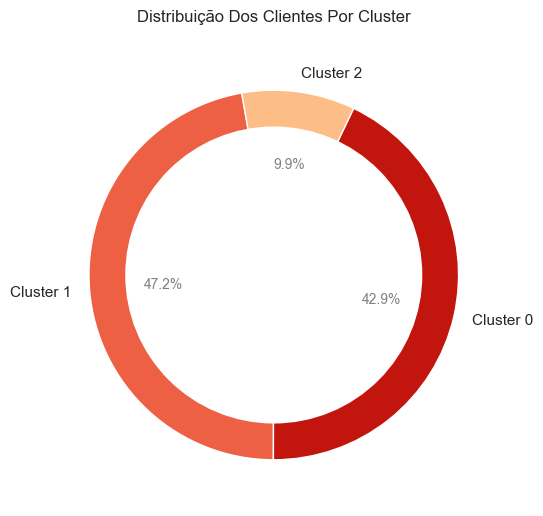

In [65]:
custom_colors = ['#ed6044', '#c2150d', '#fdbd86']
plt.figure(figsize=(10, 6))

# Desenhar o gráfico de pizza com as quantidades e as cores personalizadas
wedges, texts, autotexts = plt.pie(df_cluster['Porcentagem (%)'], labels=df_cluster['Cluster'],
                                   autopct='%1.1f%%', startangle=100, colors=custom_colors)  # Adicione a lista de cores personalizadas

# Configurar as propriedades dos textos
plt.setp(autotexts, size=10, color='grey')

centre_circle = plt.Circle((0, 0), 0.8, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribuição Dos Clientes Por Cluster', y=1.03)
plt.show()

## Avaliando Métricas

In [112]:
# Métricas
sil_score = silhouette_score(data_pca, clusters)
calinski_score = calinski_harabasz_score(data_pca, clusters)
davies_score = davies_bouldin_score(data_pca, clusters)

# Dataframe para visualização das métricas
df_metricas = pd.DataFrame({
    "Métricas": ["Silhouette Score", "Calinski Harabasz Score", "Davies Bouldin Score"],
    "Valor": [sil_score, calinski_score, davies_score]
})


df_metricas

,Métricas,Valor
0,Silhouette Score,0.482759
1,Calinski Harabasz Score,5284.018923
2,Davies Bouldin Score,0.736223


- **Silhouette Score**: O Silhouette Score varia de -1 a 1. Valores próximos a 1 indicam que os clusters estão bem separados, enquanto valores próximos a -1 sugerem que as instâncias foram atribuídas aos clusters errados. No seu caso, um valor de 0.496 é relativamente alto e sugere que os clusters têm uma boa separação.

- **Calinski Harabasz Score**: O Calinski Harabasz Score é uma métrica que avalia a dispersão entre e dentro dos clusters. Quanto maior o valor, melhor definidos são os clusters. Um valor de 5325.11 é considerado alto e sugere que os clusters estão bem definidos.

- **Davies Bouldin Score**: O Davies Bouldin Score avalia a média da similaridade entre cada cluster e seu cluster mais semelhante. Valores menores indicam melhor separação entre os clusters. Um valor de 0.7257 é geralmente considerado razoável.

### No geral, o modelo teve um ótimo resultado

In [28]:
# Salvando DF para a etapa de geração de insights 
dados_clientes.to_csv('../data/dados_clientes_clusterizadosTESTE.csv', sep =',', index = True, encoding = 'utf-8')